### FCNN

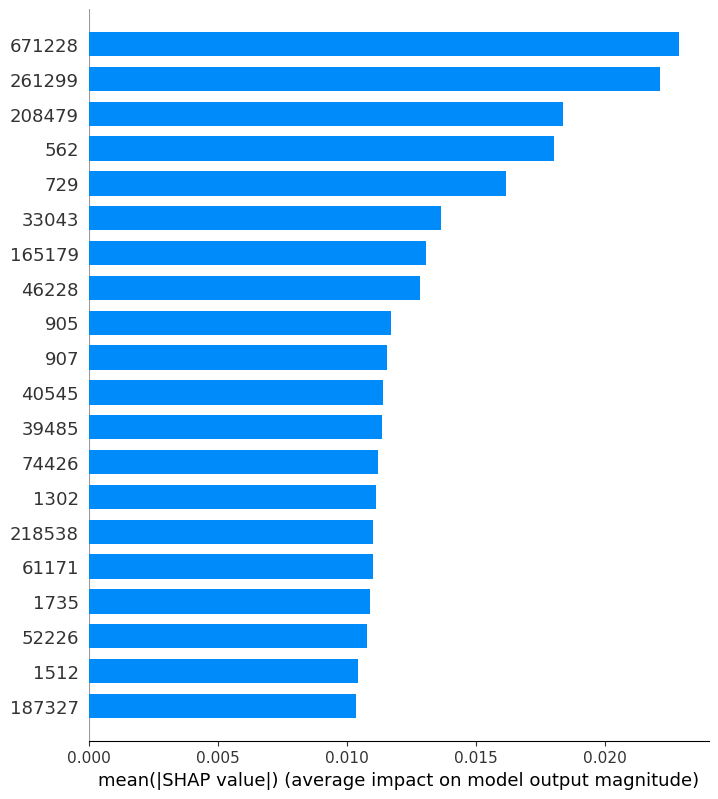

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


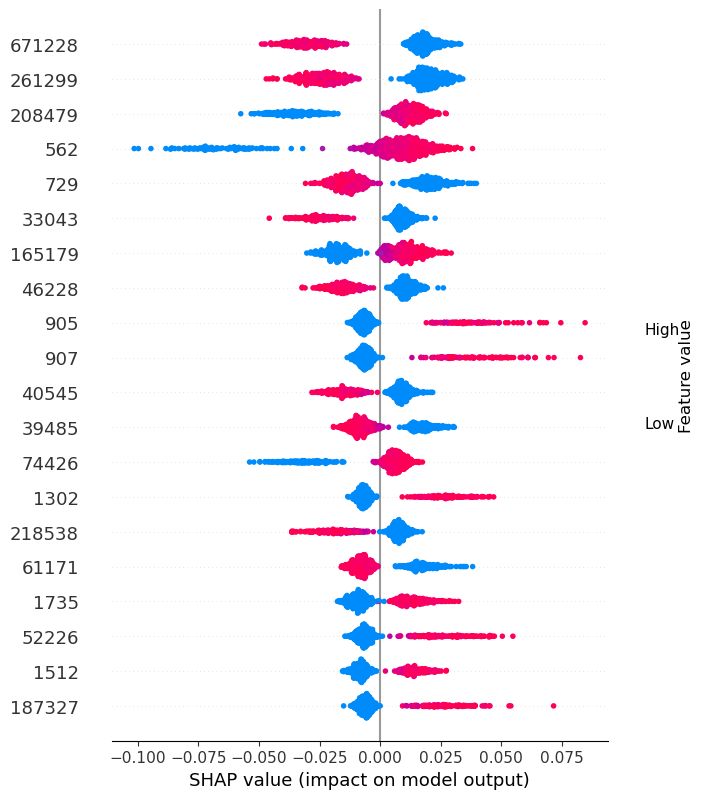

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "Results/FCNN_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"Results/FCNN_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("Results/FCNN_plots/avg_shap_values.csv", index=False)

# Display SHAP summary plot in the Jupyter notebook
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)


### FCNN_encoder_confounder_free

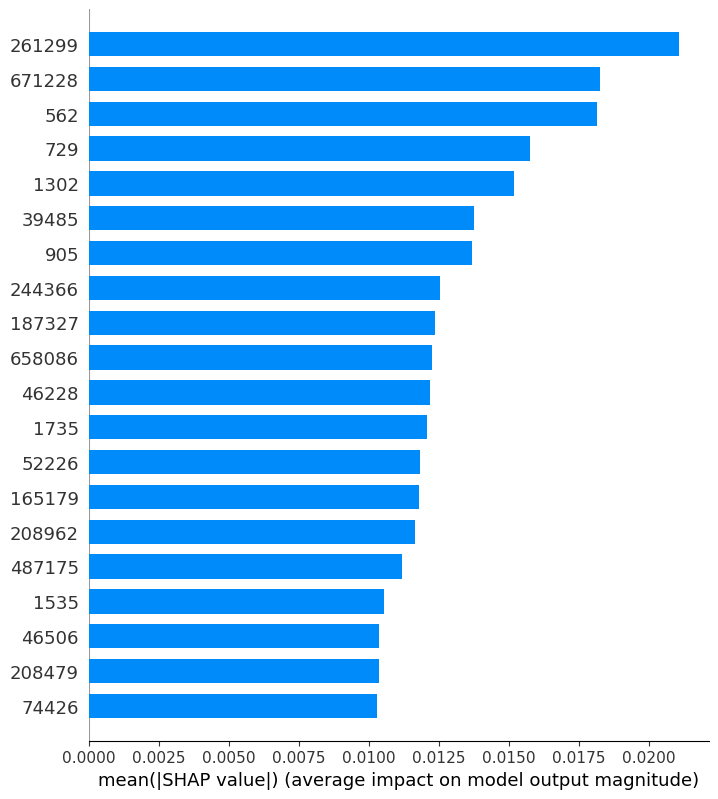

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


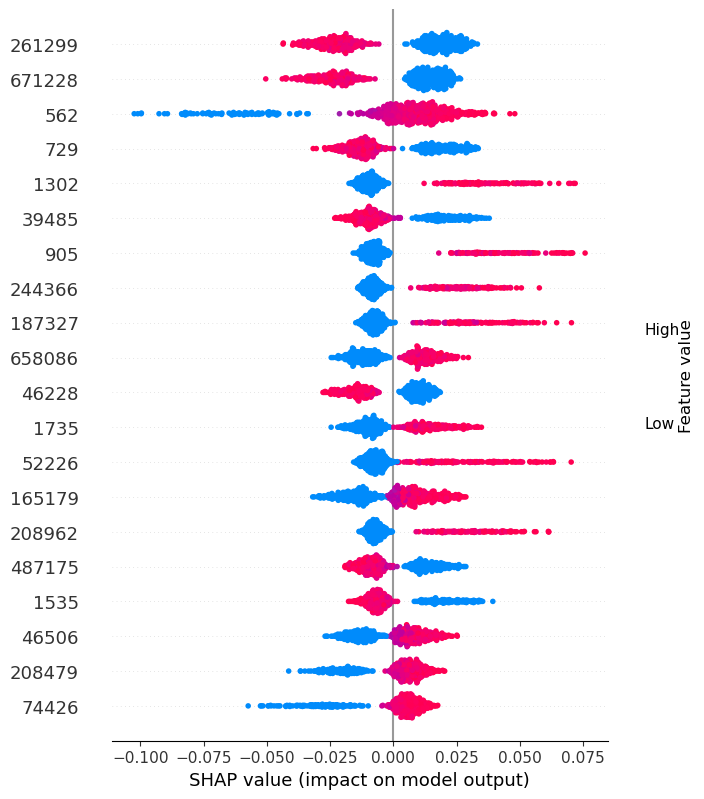

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "Results/FCNN_encoder_confounder_free_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"Results/FCNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv", index=False)

# Display SHAP summary plot in the Jupyter notebook
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)


### comparison 

features that are importsnt in the fcnn but not important in the fcnn_encpoder_confounder_free. 
* Interpret the Results

**High Positive Differences**: These indicate features where the confounded model (Model 1) assigns much higher importance compared to the confounder-free model (Model 2). This suggests that these features may be influenced by the confounder (e.g., Metformin).

**Low or No Differences**: Features with little to no difference are likely not affected by the confounder.

In [10]:
import pandas as pd
import numpy as np

# Load SHAP values for the first model (confounded)
shap_df_model1 = pd.read_csv("Results/FCNN_plots/avg_shap_values.csv")

# Load SHAP values for the second model (confounder-free)
shap_df_model2 = pd.read_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv")

# Load feature names
feature_columns = shap_df_model1.columns.tolist()


In [11]:
# Mean absolute SHAP values for each feature in both models
mean_abs_shap_model1 = shap_df_model1.abs().mean(axis=0)
mean_abs_shap_model2 = shap_df_model2.abs().mean(axis=0)


In [14]:
# Calculate the difference in mean absolute SHAP values
shap_diff = mean_abs_shap_model1 - mean_abs_shap_model2

# Find features where the SHAP value difference is significant (e.g., above a threshold)
threshold = 0.001  # You can adjust this threshold based on your data
important_in_model1 = shap_diff[shap_diff > threshold]

# Display the features important in Model 1 but not in Model 2
print("Features important in Model 1 (confounded) but not in Model 2 (confounder-free):")
print(important_in_model1)


Features important in Model 1 (confounded) but not in Model 2 (confounder-free):
1660      0.001349
28117     0.001266
169435    0.001159
47678     0.001175
626929    0.001247
817       0.002562
1683      0.001580
53443     0.001791
76517     0.001528
457421    0.002243
208479    0.008038
1547      0.002804
84030     0.004190
29348     0.002179
1512      0.002715
100884    0.002826
33043     0.004567
218538    0.005502
469613    0.003428
1736      0.001136
39496     0.001875
46124     0.001330
61171     0.003915
1613      0.001924
907       0.001255
2173      0.001532
28118     0.001315
165179    0.001255
106588    0.001400
301301    0.001876
2047      0.001008
45634     0.001533
28037     0.004205
1313      0.002396
40545     0.006030
154288    0.002180
39777     0.001871
29466     0.001949
671228    0.004636
172901    0.001125
261299    0.001059
40520     0.001814
dtype: float64


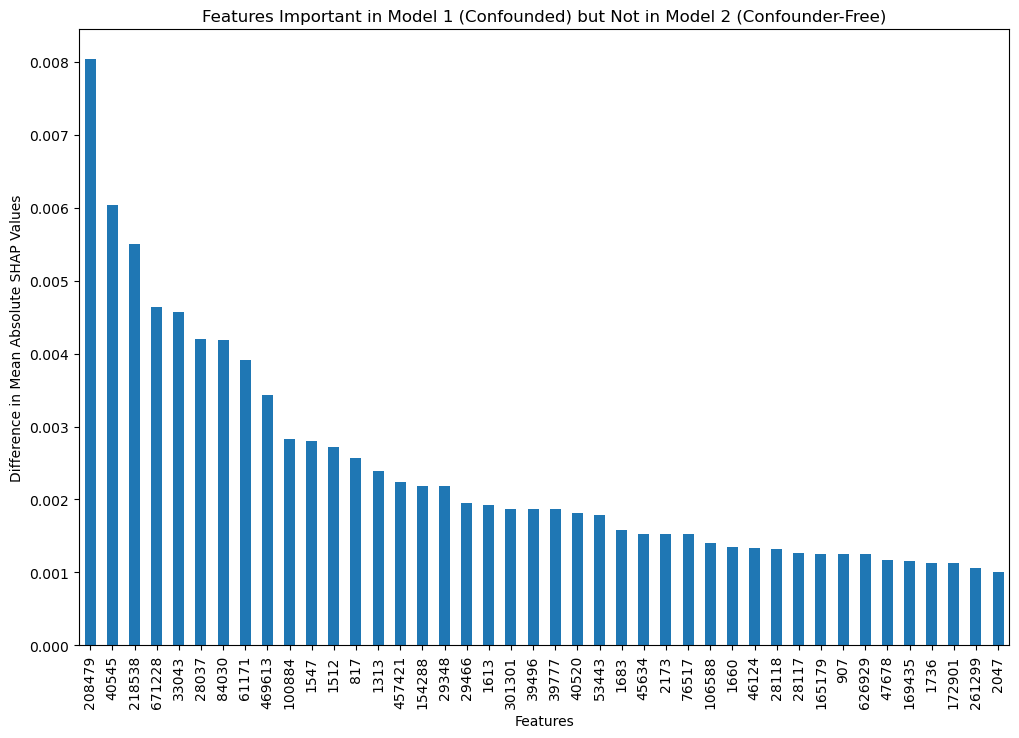

In [15]:
import matplotlib.pyplot as plt

# Sort the features by the difference in SHAP values
important_in_model1_sorted = important_in_model1.sort_values(ascending=False)

# Plot the differences
plt.figure(figsize=(12, 8))
important_in_model1_sorted.plot(kind='bar')
plt.title("Features Important in Model 1 (Confounded) but Not in Model 2 (Confounder-Free)")
plt.xlabel("Features")
plt.ylabel("Difference in Mean Absolute SHAP Values")
plt.show()


Check the ones that a realistic benchmark paper show as a sconfounded species

   Species  Model 1 (Confounded)  Model 2 (Confounder-Free)  Difference
0   457421              0.005003                   0.002760    0.002243
1   908340              0.001963                   0.006049   -0.004086
2    29347              0.001942                   0.002761   -0.000819
3   638849              0.003767                   0.005742   -0.001976
4   360807              0.003916                   0.006300   -0.002384
5     1322              0.001416                   0.001500   -0.000084
6      817              0.006698                   0.004136    0.002562
7   261299              0.022131                   0.021071    0.001059
8      853              0.001521                   0.001963   -0.000442
9    88431              0.001713                   0.002481   -0.000768
10   40520              0.006610                   0.004796    0.001814
11   39496              0.003463                   0.001589    0.001875
12   39491              0.001601                   0.003466   -0

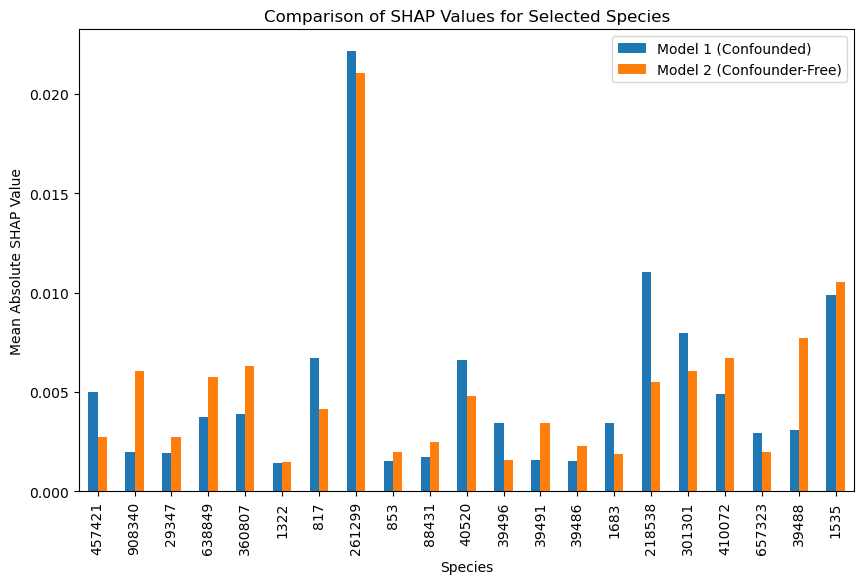

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load SHAP values for the confounded model
shap_df_model1 = pd.read_csv("Results/FCNN_plots/avg_shap_values.csv")

# Load SHAP values for the confounder-free model
shap_df_model2 = pd.read_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv")

# Load feature (species) names
feature_columns = pd.read_csv("Results/FCNN_plots/feature_columns.csv", header=None).squeeze("columns").astype(str).tolist()

# List of species you want to check
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535', ]  # Replace with actual species names

# Get the mean absolute SHAP values for the selected species in both models
mean_abs_shap_model1 = shap_df_model1.abs().mean(axis=0)
mean_abs_shap_model2 = shap_df_model2.abs().mean(axis=0)

# Filter the SHAP values for the selected species
shap_comparison = pd.DataFrame({
    'Species': species_to_check,
    'Model 1 (Confounded)': [mean_abs_shap_model1[species] for species in species_to_check],
    'Model 2 (Confounder-Free)': [mean_abs_shap_model2[species] for species in species_to_check]
})

# Calculate the difference
shap_comparison['Difference'] = shap_comparison['Model 1 (Confounded)'] - shap_comparison['Model 2 (Confounder-Free)']

# Display the comparison
print(shap_comparison)

# Plot the comparison
shap_comparison.set_index('Species')[['Model 1 (Confounded)', 'Model 2 (Confounder-Free)']].plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of SHAP Values for Selected Species")
plt.ylabel("Mean Absolute SHAP Value")
plt.show()


Species with Significant Differences in SHAP Values:
   Species  Difference   p-value  Significant
0   457421    0.001339  0.404301        False
1   908340   -0.001856  0.318962        False
2    29347    0.000079  0.888991        False
3   638849   -0.001995  0.158096        False
4   360807   -0.001867  0.181295        False
5     1322    0.000583  0.533895        False
6      817    0.001913  0.234614        False
7   261299    0.001061  0.800710        False
8      853   -0.000527  0.616805        False
9    88431    0.000117  0.928010        False
10   40520    0.001702  0.394280        False
11   39496    0.001970  0.098109        False
12   39491   -0.000452  0.602191        False
13   39486    0.000313  0.611347        False
14    1683    0.001250  0.154838        False
15  218538    0.004036  0.065880        False
16  301301    0.001612  0.285580        False
17  410072   -0.001476  0.502308        False
18  657323    0.001572  0.171968        False
19   39488   -0.001669  0.2

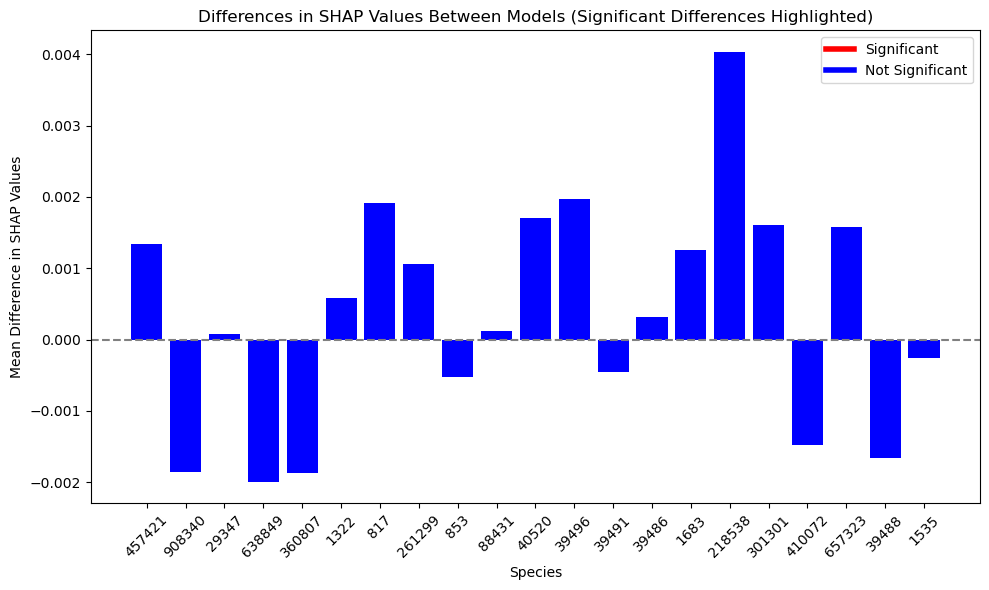

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Load SHAP values for the confounded model (5 folds)
shap_values_model1 = [pd.read_csv(f"Results/FCNN_plots/shap_values_fold{fold}.csv").values for fold in range(1, 6)]

# Load SHAP values for the confounder-free model (5 folds)
shap_values_model2 = [pd.read_csv(f"Results/FCNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv").values for fold in range(1, 6)]

# Load feature (species) names
feature_columns = pd.read_csv("Results/FCNN_plots/feature_columns.csv", header=None).squeeze("columns").astype(str).tolist()

# Convert SHAP values lists to NumPy arrays
shap_values_model1 = np.array(shap_values_model1)  # Shape: (5, num_samples, num_features)
shap_values_model2 = np.array(shap_values_model2)  # Shape: (5, num_samples, num_features)

# Calculate the mean absolute SHAP values for each fold and each feature
mean_abs_shap_model1 = np.abs(shap_values_model1).mean(axis=1)  # Shape: (5, num_features)
mean_abs_shap_model2 = np.abs(shap_values_model2).mean(axis=1)  # Shape: (5, num_features)

# List of species to check
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535', ]  # Replace with actual species names

# Perform paired t-test for each species
p_values = []
differences = []

for species in species_to_check:
    idx = feature_columns.index(species)
    diff = mean_abs_shap_model1[:, idx] - mean_abs_shap_model2[:, idx]
    differences.append(diff.mean())
    t_stat, p_val = ttest_rel(mean_abs_shap_model1[:, idx], mean_abs_shap_model2[:, idx])
    p_values.append(p_val)

# Create a DataFrame with results
results_df = pd.DataFrame({
    'Species': species_to_check,
    'Difference': differences,
    'p-value': p_values
})

# Add a significance column based on a threshold (e.g., 0.05)
results_df['Significant'] = results_df['p-value'] < 0.05

# Display the results
print("Species with Significant Differences in SHAP Values:")
print(results_df)

# Plot the differences with significance highlighted
plt.figure(figsize=(10, 6))
colors = ['red' if sig else 'blue' for sig in results_df['Significant']]
plt.bar(results_df['Species'], results_df['Difference'], color=colors)
plt.axhline(0, color='grey', linestyle='--')
plt.title("Differences in SHAP Values Between Models (Significant Differences Highlighted)")
plt.ylabel("Mean Difference in SHAP Values")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.legend(handles=[plt.Line2D([0], [0], color='red', lw=4, label='Significant'),
                    plt.Line2D([0], [0], color='blue', lw=4, label='Not Significant')])
plt.tight_layout()
plt.show()
